In [1]:
%cd ..

/home/pauline/Dokumente/Delab_Projekt/delab


In [2]:
import pandas as pd

In [3]:
from util.sql_switch import get_query_native

authors_tweets = get_query_native(
    "SELECT ta.id as author_id, conversation_id, screen_name , is_climate_author, climate_author_type FROM delab_tweet t, delab_tweetauthor ta WHERE t.author_id=ta.twitter_id")
clauthors_tweets = authors_tweets.loc[authors_tweets['is_climate_author']== True]


clauthors_tweets = clauthors_tweets.replace(['non-governmental organisation'], 'NGO')
clauthors_tweets = clauthors_tweets.groupby(["author_id", "screen_name", "climate_author_type","conversation_id"]).mean()

c_cam = get_query_native(
    "SELECT author_id, is_root_author, c.conversation_id, depth, branching_factor, centrality, baseline_vision, n_posts FROM delab_conversation c, delab_conversationauthormetrics cam WHERE c.conversation_id=cam.conversation_id")
c_cam = c_cam.groupby(["author_id", "conversation_id"]).mean()

analysis = clauthors_tweets.join(c_cam)
analysis_flattened = analysis.reset_index()
analysis_flattened

using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts
0,1,1414150136607948808,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1427328275773280265,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1509780204948017154,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1521343957086740486,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1532708095704580100,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9137,1618,1610320983872634881,climate_ice,scientist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9138,1619,1519656711455313921,EricTopol,scientist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9139,1619,1530931490636255232,EricTopol,scientist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9140,1619,1593290345646694401,EricTopol,scientist,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
analysis_flattened.loc[analysis_flattened.index== 4935]

,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts
4935,378,1581636347743199239,KathrinAnna,politician,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
authors_tweets = get_query_native(
    "SELECT ta.id as author_id, conversation_id, screen_name , is_climate_author, climate_author_type FROM delab_tweet t, delab_tweetauthor ta WHERE t.author_id=ta.twitter_id")
clauthors_tweets = authors_tweets.loc[authors_tweets['is_climate_author']== True]
len(clauthors_tweets.groupby('author_id').count())

using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


171

In [5]:
author = analysis.groupby('author_id').count()


In [6]:
tweet_ids = get_query_native(
                "SELECT conversation_id FROM delab_tweet")
tweet_ids
tweet_count = tweet_ids['conversation_id'].value_counts()
tweet_count = tweet_count.to_frame()
tweet_count = tweet_count.rename(columns={"conversation_id":"n_posts"})
tweet_count['conversation_id'] = tweet_count.index
tweet_count

using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,n_posts,conversation_id
1603181423787380737,190875,1603181423787380737
1608175680407191552,81226,1608175680407191552
1612973043583696897,77559,1612973043583696897
1607677190254235648,75456,1607677190254235648
1608188826291167242,43518,1608188826291167242
...,...,...
1590643169326428161,6,1590643169326428161
1498566439497867264,6,1498566439497867264
1589319384220446720,6,1589319384220446720
1543611263816695808,6,1543611263816695808


In [9]:
mapped_columns = dict(zip(tweet_count.conversation_id, tweet_count.n_posts))
analysis_flattened["total_counts"] = analysis_flattened["conversation_id"].map(mapped_columns)
analysis_flattened

,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,total_counts
0,1,1575916410295009308,mnyomb1,activist,1.0,1.0,3.0,5.0,3.500000,0.500000,1.0,6
1,1,1578084206940487680,mnyomb1,activist,1.0,1.0,3.0,5.0,2.000000,0.250000,2.0,6
2,1,1582639690309828609,mnyomb1,activist,1.0,1.0,6.0,59.0,14.138889,0.185547,3.0,60
3,1,1585616351493820416,mnyomb1,activist,1.0,1.0,3.0,21.0,1.444444,0.118056,9.0,22
4,1,1597566310191624196,mnyomb1,activist,1.0,1.0,9.0,20.0,1.100000,0.057031,10.0,21
...,...,...,...,...,...,...,...,...,...,...,...,...
380,1613,1622246662180683779,hausfath,scientist,1.0,0.0,7.0,39.0,4.916667,0.075195,2.0,40
381,1616,1619456016638427136,ed_hawkins,scientist,1.0,1.0,5.0,137.0,22.100000,0.156250,5.0,143
382,1617,1619442074990055425,PeterGleick,scientist,1.0,0.0,14.0,144.0,4.015385,0.093750,1.0,145
383,1617,1619506977343934466,PeterGleick,scientist,1.0,1.0,5.0,10.0,1.750000,0.285156,2.0,11


## Analyse
- Nach climate_author_type analysieren
- Fragen:
    - in wievielen Konversationen sind die Autoren durchschnittlich vertreten?
    - welche Zentralität haben die AUtoren durchschnittlich?
    - welche root dominance haben die Autoren durchschnittlich?
    - welchen branching_factor und welche depth haben die Konversationen, in denen die Autoren root auhtor sind duchschnittlich?
    

In [10]:
climate_analysis = analysis_flattened.groupby(['climate_author_type']).mean()
climate_analysis = climate_analysis.drop(columns=['author_id', 'conversation_id', 'is_climate_author', 'is_root_author' ])
#climate_analysis = climate_analysis.drop('journalist') #bisher sind alle ergebnisse für journalists NaN, deswegen werden wir sie nicht betrachten
climate_analysis

,depth,branching_factor,centrality,baseline_vision,n_posts,total_counts
climate_author_type,,,,,,
NGO,5.791667,135.625000,40.106405,0.371460,2.250000,136.666667
activist,9.363636,500.054545,17.299571,0.286902,2.854545,502.654545
journalist,10.906250,107.375000,28.918540,0.261238,2.968750,108.375000
organisation,3.634615,26.576923,21.210029,0.437599,2.000000,27.923077
politician,5.095238,48.047619,14.257766,0.315932,1.904762,49.047619
scientist,8.453125,103.882812,20.534967,0.268312,3.375000,104.232558


In [11]:
import matplotlib.pyplot as plt
import numpy as np

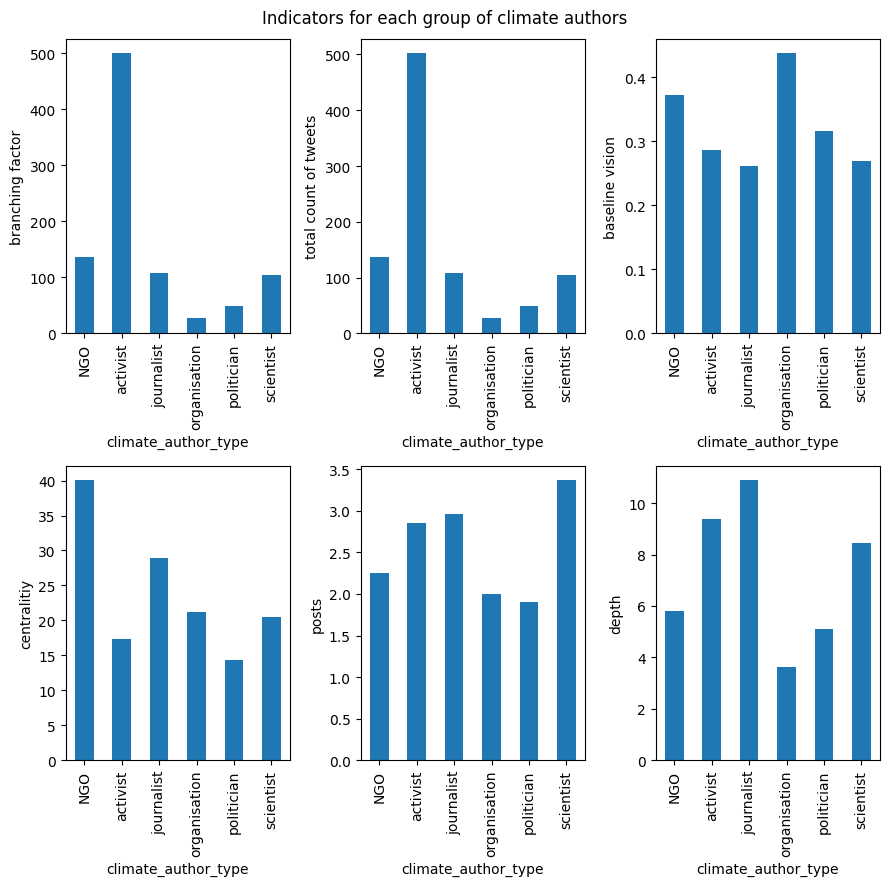

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(9,9))
fig.suptitle("Indicators for each group of climate authors")

ax1 = climate_analysis['branching_factor'].plot.bar(ax=axes[0,0])
ax1.set_ylabel("branching factor")

ax2 = climate_analysis['total_counts'].plot.bar(ax=axes[0,1])
ax2.set_ylabel("total count of tweets")

ax3 = climate_analysis['centrality'].plot.bar(ax=axes[1,0])
ax3.set_ylabel("centralitiy")

ax4 = climate_analysis['n_posts'].plot.bar(ax=axes[1,1])
ax4.set_ylabel("posts");

ax5 = climate_analysis['baseline_vision'].plot.bar(ax=axes[0,2])
ax5.set_ylabel("baseline vision")

ax6 = climate_analysis['depth'].plot.bar(ax=axes[1,2])
ax6.set_ylabel("depth");

In [26]:
analysis_flattened.describe()

,author_id,conversation_id,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,total_counts
count,385.000000,3.850000e+02,385.0,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,385.000000
mean,355.633766,1.611657e+18,1.0,0.890625,7.286458,155.330729,25.411185,0.321701,2.718750,156.264935
std,289.140471,1.157589e+16,0.0,0.312516,7.531395,803.336091,77.226669,0.180097,3.754067,802.291456
min,1.000000,1.575844e+18,1.0,0.000000,2.000000,5.000000,0.000000,0.018519,1.000000,6.000000
25%,103.000000,1.603646e+18,1.0,1.000000,3.000000,10.000000,3.500000,0.142122,1.000000,11.000000
50%,379.000000,1.616044e+18,1.0,1.000000,4.000000,20.000000,7.183333,0.285156,1.000000,21.000000
75%,407.000000,1.620393e+18,1.0,1.000000,8.000000,60.500000,15.816667,0.500000,3.000000,63.000000
max,1617.000000,1.622427e+18,1.0,1.000000,47.000000,13789.000000,948.726825,0.500000,31.000000,13790.000000


<AxesSubplot:xlabel='x1', ylabel='total_counts'>

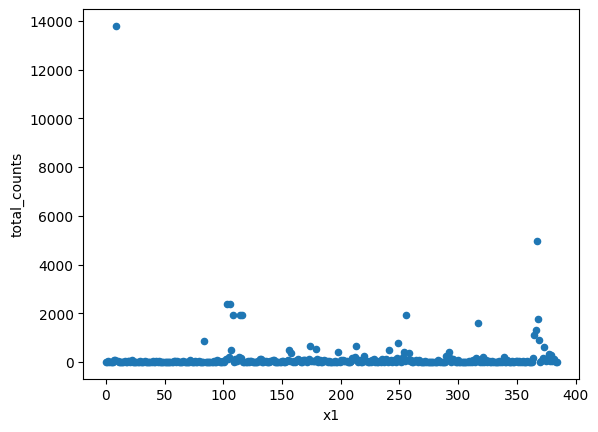

In [27]:
scatter_analysis = analysis_flattened.reset_index()
scatter_analysis = scatter_analysis[scatter_analysis.total_counts > 1]
scatter_analysis['x1'] = scatter_analysis.index
scatter_analysis
scatter_analysis.plot.scatter(x='x1', y="total_counts")

<AxesSubplot:xlabel='x1', ylabel='branching_factor'>

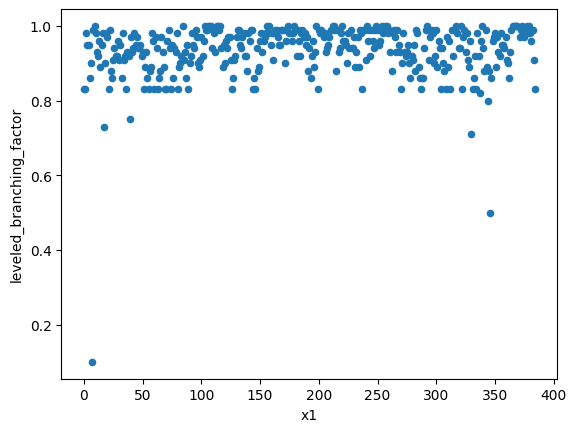

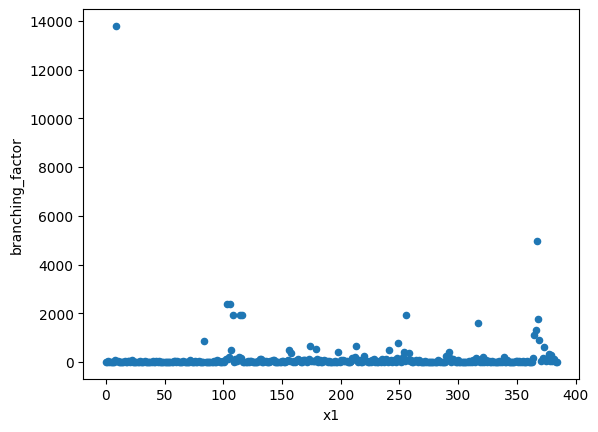

In [28]:
scatter_analysis['leveled_branching_factor']= (scatter_analysis["branching_factor"]/scatter_analysis["total_counts"]).round(2)
scatter_analysis.plot.scatter(x='x1', y="leveled_branching_factor")
scatter_analysis.plot.scatter(x='x1', y="branching_factor")
#Teilen durch total_counts hilft gegen ausreißer

In [29]:
scatter_analysis_case_study = scatter_analysis[scatter_analysis["leveled_branching_factor"] < 0.75]
scatter_analysis_case_study
print(scatter_analysis["leveled_branching_factor"].mean())


0.935546875


<AxesSubplot:xlabel='x1', ylabel='leveled_depth'>

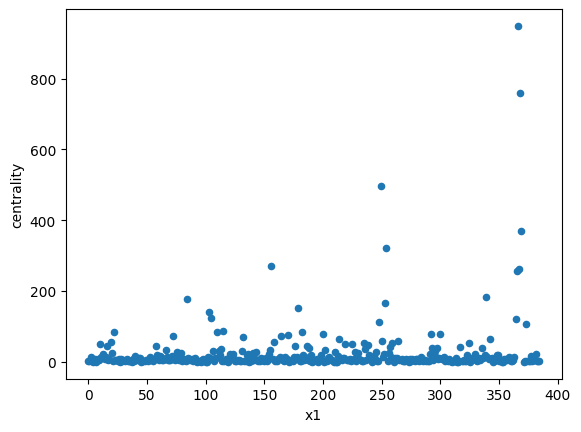

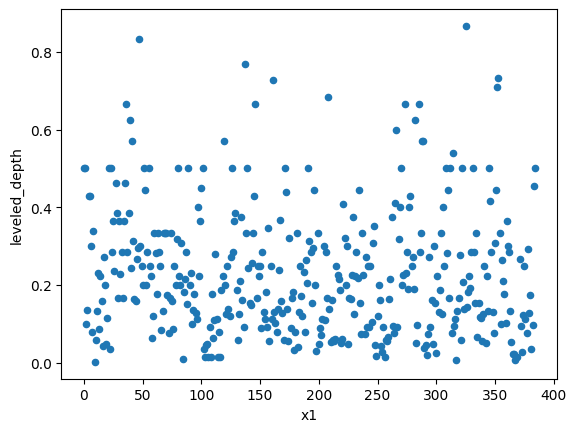

In [30]:
scatter_analysis.plot.scatter(x='x1', y="centrality")
scatter_analysis['leveled_depth']= (scatter_analysis["depth"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_depth")

<AxesSubplot:xlabel='x1', ylabel='leveled_centrality'>

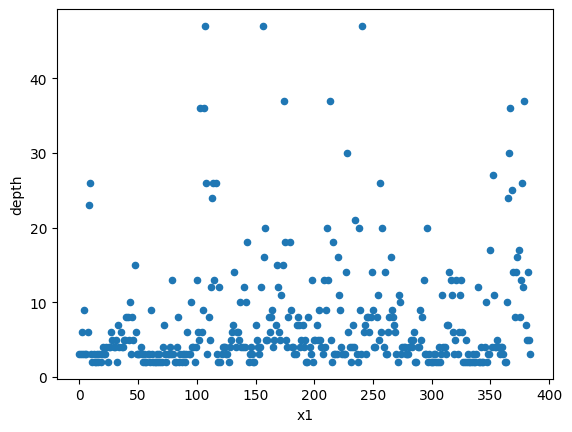

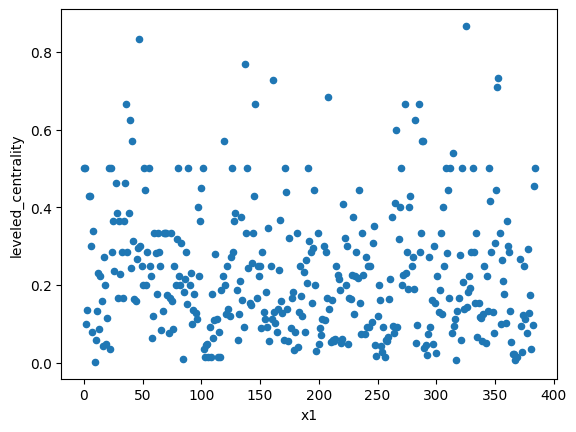

In [31]:
scatter_analysis.plot.scatter(x='x1', y="depth")
scatter_analysis['leveled_centrality']= (scatter_analysis["depth"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_centrality")

<AxesSubplot:xlabel='x1', ylabel='leveled_baseline_vision'>

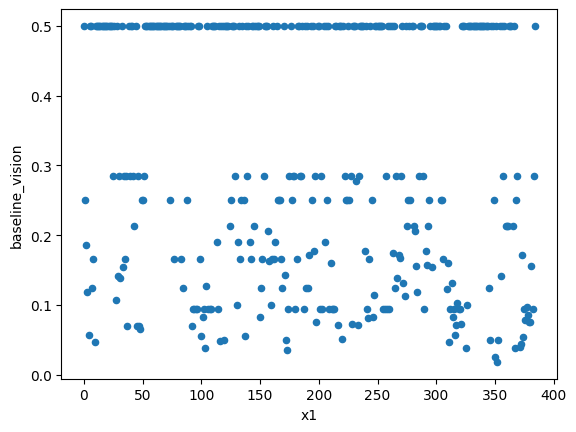

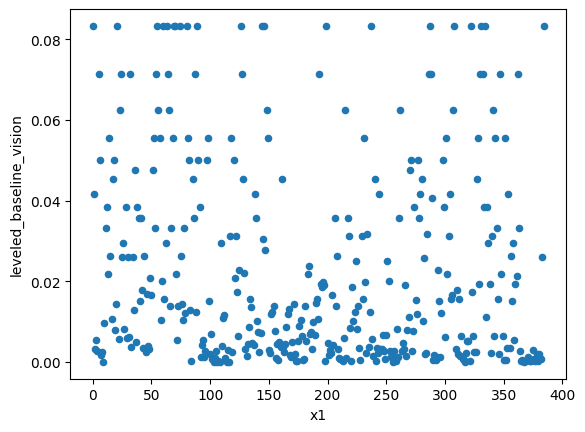

In [32]:
scatter_analysis.plot.scatter(x='x1', y="baseline_vision")
scatter_analysis['leveled_baseline_vision']= (scatter_analysis["baseline_vision"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_baseline_vision")
#Macht es hier Sinn durch die Anzahl der Tweets in der Konversation zu teilen?

<AxesSubplot:xlabel='x1', ylabel='leveled_posts'>

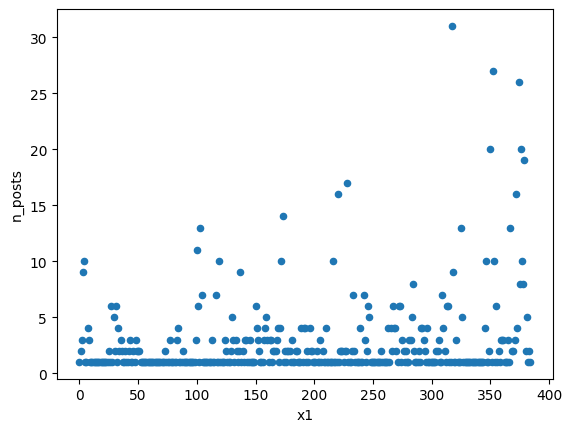

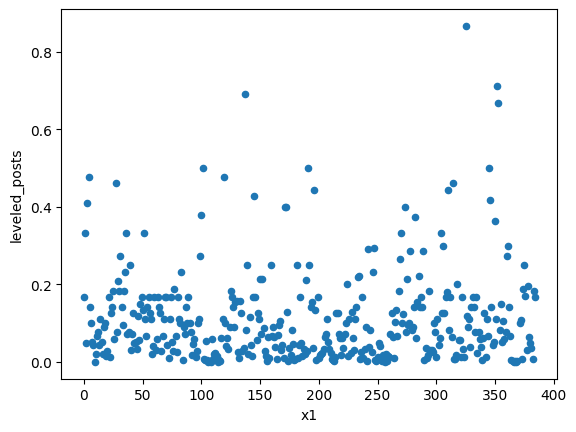

In [33]:
scatter_analysis.plot.scatter(x='x1', y="n_posts")
scatter_analysis['leveled_posts']= (scatter_analysis["n_posts"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_posts")

Konversation 3 viele Posts vom Root author aber baseline vision vom root author besonders niedrig

In [42]:
leveled_analysis = climate_analysis
leveled_analysis['leveled_depth'] = (leveled_analysis["depth"]/leveled_analysis["total_counts"])
leveled_analysis['leveled_branching_factor'] = (leveled_analysis["branching_factor"]/leveled_analysis["total_counts"])
leveled_analysis['leveled_centrality'] = (leveled_analysis["centrality"]/leveled_analysis["total_counts"])
leveled_analysis['leveled_baseline_vision'] = (leveled_analysis["baseline_vision"]/leveled_analysis["total_counts"])
leveled_analysis['leveled_posts'] = (leveled_analysis["n_posts"]/leveled_analysis["total_counts"])
leveled_analysis

,depth,branching_factor,centrality,baseline_vision,n_posts,total_counts,leveled_branching_factor,leveled_depth,leveled_centrality,leveled_baseline_vision,leveveled_posts,leveled_posts
climate_author_type,,,,,,,,,,,,
NGO,5.791667,135.625000,40.106405,0.371460,2.250000,136.666667,0.992378,0.042378,0.293462,0.002718,0.016463,0.016463
activist,9.363636,500.054545,17.299571,0.286902,2.854545,502.654545,0.994827,0.018628,0.034416,0.000571,0.005679,0.005679
journalist,10.906250,107.375000,28.918540,0.261238,2.968750,108.375000,0.990773,0.100634,0.266838,0.002411,0.027393,0.027393
organisation,3.634615,26.576923,21.210029,0.437599,2.000000,27.923077,0.951791,0.130165,0.759588,0.015672,0.071625,0.071625
politician,5.095238,48.047619,14.257766,0.315932,1.904762,49.047619,0.979612,0.103883,0.290692,0.006441,0.038835,0.038835
scientist,8.453125,103.882812,20.534967,0.268312,3.375000,104.232558,0.996645,0.081099,0.197011,0.002574,0.032380,0.032380


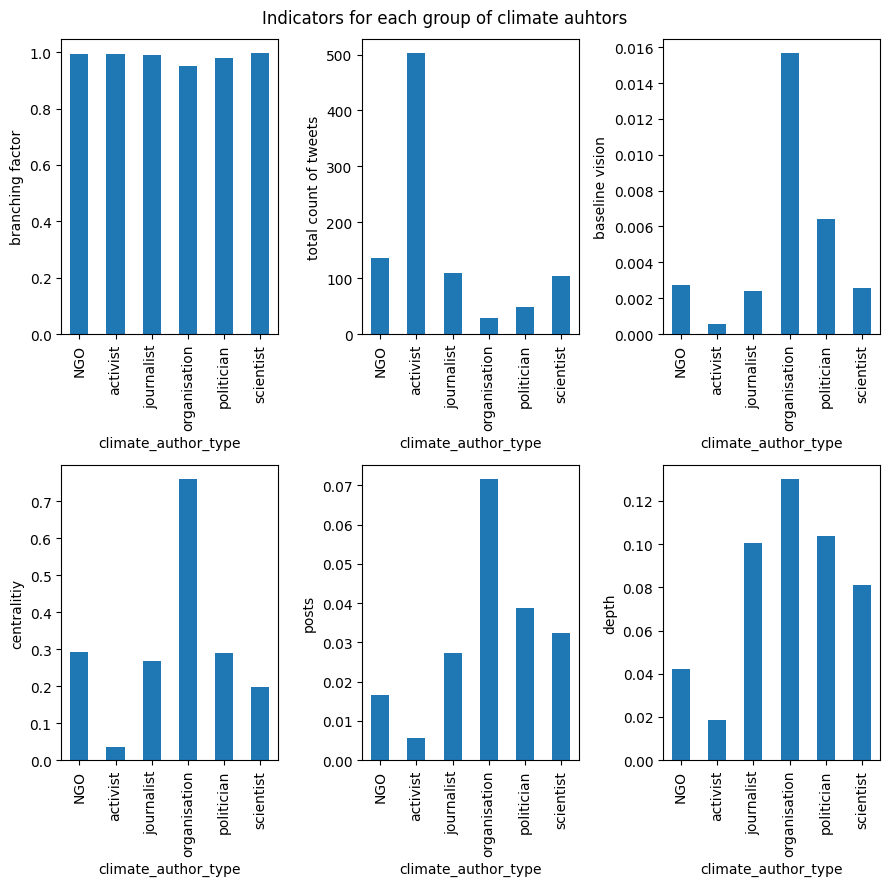

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(9,9))
fig.suptitle("Indicators for each group of climate auhtors")

ax1 = leveled_analysis['leveled_branching_factor'].plot.bar(ax=axes[0,0])
ax1.set_ylabel("branching factor")

ax2 = leveled_analysis['total_counts'].plot.bar(ax=axes[0,1])
ax2.set_ylabel("total count of tweets")

ax3 = leveled_analysis['leveled_centrality'].plot.bar(ax=axes[1,0])
ax3.set_ylabel("centralitiy")

ax4 = leveled_analysis['leveled_posts'].plot.bar(ax=axes[1,1])
ax4.set_ylabel("posts");

ax5 = leveled_analysis['leveled_baseline_vision'].plot.bar(ax=axes[0,2])
ax5.set_ylabel("baseline vision")

ax6 = leveled_analysis['leveled_depth'].plot.bar(ax=axes[1,2])
ax6.set_ylabel("depth");